In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.metrics import r2_score
import sys
sys.path.append("../../utils")
import utils
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import cross_val_score

In [2]:
def poli_regression(model,degrees,img_path):
    # corr_df = model.corr()
    # if corr_df.empty:
    #     return None,None
    # correlated = corr_df.Tourists_Count.loc[(abs(corr_df.Tourists_Count)>=0.15)]
    # if len(correlated) == 0:
    #     return None,None
    # correlated = correlated.drop(['Tourists_Count']).index.tolist()
    # if len(correlated) == 0:
    #     return None,None

    

    X = model.drop(['Tourists_Count','Site_Name'],axis = 1)
    y = model.Tourists_Count
    chi_selector = SelectKBest(f_regression, k=10)
    chi_selector.fit(X, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.to_list()

    X = X[chi_feature]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7254)
    train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
    test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)

    x_train_scaler = MinMaxScaler()
    x_test_scaler = MinMaxScaler()
    y_train_scaler = MinMaxScaler()
    y_test_scaler = MinMaxScaler()
    #print(X_train)
    X_train_scaled = x_train_scaler.fit_transform(X_train)
    X_test_scaled = x_test_scaler.fit_transform(X_test)
    y_train_scaled = y_train_scaler.fit_transform(pd.DataFrame(y_train))
    y_test_scaled = y_test_scaler.fit_transform(pd.DataFrame(y_test))

    poly = PolynomialFeatures(degree=degrees)

    #fit the x variable to fit a 2rd degree polynomial value
    X_poly = poly.fit_transform(X_train_scaled)
    poly.fit(X_poly, y_train_scaled)
    pol_lin_reg = LinearRegression()
    pol_lin_reg.fit(X_poly, y_train_scaled)
    
    #predict the training data
    y_train_pred_scaled = pol_lin_reg.predict(poly.fit_transform(X_train_scaled))
    y_train_pred = y_train_scaler.inverse_transform(y_train_pred_scaled)

    #create a pandas series of the results
    y_train_pred = round(pd.Series(y_train_pred[:,0], index=y_train.index, name='predicted_entries_train'),ndigits=2)
    #Add the results to the DF
    train_df = pd.merge(left=train_df, right=y_train_pred , left_index=True, right_index=True)
    
    #train_df.head()
    y_test_pred_scaled = pol_lin_reg.predict(poly.fit_transform(X_test_scaled))
    y_test_pred = y_test_scaler.inverse_transform(y_test_pred_scaled)

    #create a pandas series of the results
    y_test_pred = round(pd.Series(y_test_pred[:,0], index=y_test.index, name='predicted_entries_test'),ndigits=2)
    
    #Add the results to the DF
    test_df = pd.merge(left=test_df, right=y_test_pred , left_index=True, right_index=True)
    train_df['residuals'] = train_df.predicted_entries_train - train_df.Tourists_Count
    test_df['residuals'] = test_df.predicted_entries_test - test_df.Tourists_Count
    fig= go.Figure()
    fig.add_trace(
        go.Scatter(
            x=train_df.predicted_entries_train,
            y=train_df.residuals,
            mode='markers',
            name='train residuals',
            marker_color='blue',
            marker_size=1.5,
            marker_line_width=0,
        )
    )
    fig.add_trace(
    go.Scatter(
        x=test_df.predicted_entries_test,
        y=test_df.residuals,
        mode='markers',
        name='test residuals',
        marker_color='red',
        marker_size=1.5,
        marker_line_width=0,
        )
    )
    fig.add_trace(
    go.Scatter(
        x=test_df.predicted_entries_test,
        y=test_df.residuals*0,
        mode='lines',
        name='zero line',
        marker_color='black',
        marker_size=1.5,
        marker_line_width=0,
        )
    )
    fig.update_layout(
        title="Residuals of Predicted Entries",
        xaxis_title="Predicted Entries",
        yaxis_title="Residuals",
        font=dict(
            size=14,
            color="RebeccaPurple"
        )
    )
    fig.write_image( img_path+'tourists_UNI_SELECTION_residuals_results_degree_'+str(degrees)+'.png',width = 1500,height = 600)
    return train_df,test_df

In [2]:
df = pd.read_excel("../../../site_info_ver_3.2.xlsx")
df.reset_index(drop=True,inplace=True)
df = df.dropna(axis = 0)
sites = df.Site_Name.unique()

#dummies = pd.get_dummies(df, columns =['Site_Name'])


In [3]:
def drop(tmp, drops):
    #to_drop = ['Tourists_Count','Israelis_Count','Total']
    cols = tmp.columns
    res = [x for x in cols if x in drops]
    return tmp.drop(res , axis = 1)
    

In [11]:
from pycaret import *

#lets choose a site
my_site_df = df.loc[df.Site_Name == 'Apollonia']
my_site_df.reset_index(drop = True)
my_site_df = drop([''])

,Date,Site_Name,Israelis_Count,Tourists_Count,Total,region_Central,region_Judea_Samaria,region_North,region_South,is_weekend,...,Tel_Aviv-Yafo_nox_exceeded,Jerusalem_nox_exceeded,Haifa_nox_exceeded,Ashkelon_nox_exceeded,Beer-Sheva_nox_exceeded,Green_border,Season_autumn,Season_spring,Season_summer,Season_winter
0,2016-01-02,Apollonia,88,10,98,1,0,0,0,1,...,1,1,1,0,1,0,0,0,0,1
1,2016-01-04,Apollonia,108,15,123,1,0,0,0,0,...,1,1,1,0,1,0,0,0,0,1
2,2016-01-05,Apollonia,48,4,52,1,0,0,0,0,...,1,1,1,0,1,0,0,0,0,1
3,2016-01-06,Apollonia,75,4,79,1,0,0,0,0,...,1,1,1,0,1,0,0,0,0,1
4,2016-01-07,Apollonia,56,0,56,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,2021-08-03,Apollonia,223,0,223,1,0,0,0,0,...,1,1,1,0,1,0,0,0,1,0
761,2021-08-06,Apollonia,38,0,38,1,0,0,0,1,...,1,1,1,0,1,0,0,0,1,0
762,2021-08-07,Apollonia,83,0,83,1,0,0,0,1,...,1,1,1,0,1,0,0,0,1,0
763,2021-08-09,Apollonia,321,0,321,1,0,0,0,0,...,1,1,1,0,0,0,0,0,1,0


model : by site characteristics

In [23]:
water_sites = df.loc[df.is_water == 1]
arch_sites = df.loc[df.is_archaeology == 1]
water_sites = water_sites.dropna(axis = 0)
arch_sites = arch_sites.dropna(axis = 0)
#cleaning un relevant columns and stuff..
cols = ['Tourists_Count','Israelis_Count','Total','Date','Model_number','Site_Name']

lookout_sites = df.loc[df.is_lookout == 1]
lookout_sites = lookout_sites.dropna(axis = 0)


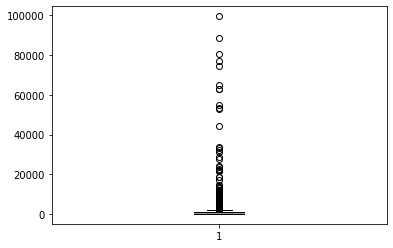

In [32]:
def remove_high_corr(df2,target,threshold):

  target_col = df2.pop(target)
  df2.insert(len(df2.columns), target, target_col)
  cor_matrix = df2.corr().abs()
  corr_df2 = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
  #מתודה שאומרת בי בקורלורציה עם מי
  cols = corr_df2.columns.to_list()
  list_corr_not_empty=[]

  for i in range(len(cols)-1):
      tmp = []
      for j in range(len(cols)-1):
        if abs(corr_df2.iloc[i,j]) >= threshold and cols[i] is not cols[j] :
          tmp.append(cols[j])
      if len(tmp)>0:
          tmp.append(cols[i])
          list_corr_not_empty.append(tmp)
  def key(p):
   return  corr_df2[target][p]
  stay = [max(sub,key=key) for sub in list_corr_not_empty]
  drops = [ c for sub in list_corr_not_empty for c in sub if c not in stay ]
  return list(set(drops))

def remove_outliers(df,target_name):
  
  plt.cla()
  bp = plt.boxplot(df[target_name])
  minimums = [round(item.get_ydata()[0], 4) for item in bp['caps']][::2]
  maximums = [round(item.get_ydata()[0], 4) for item in bp['caps']][1::2]
  return df.drop(df [ (df[target_name]>maximums[0])  | (df[target_name]<minimums[0])].index)

drops = remove_high_corr(lookout_sites,'Total',0.4)
tmp1  = water_sites.drop(drops,axis = 1)
tmp1 = remove_outliers(tmp1,'Total')

In [38]:

pollutions_cols = ['pm10', 'pm2.5','nox', 'so2','Tel_Aviv-Yafo_pm10',
       'Jerusalem_pm10', 'Haifa_pm10', 'Ashkelon_pm10', 'Beer-Sheva_pm10',
       'Tel_Aviv-Yafo_pm2.5', 'Jerusalem_pm2.5', 'Haifa_pm2.5',
       'Ashkelon_pm2.5', 'Beer-Sheva_pm2.5', 'Tel_Aviv-Yafo_nox',
       'Jerusalem_nox', 'Haifa_nox', 'Ashkelon_nox', 'Beer-Sheva_nox',
       'Tel_Aviv-Yafo_so2', 'Jerusalem_so2', 'Haifa_so2', 'Ashkelon_so2',
       'Beer-Sheva_so2', 'is_Site_exceeded_pm10', 'is_Site_exceeded_pm2.5',
       'is_Site_exceeded_nox', 'is_Site_exceeded_so2',
       'Tel_Aviv-Yafo_pm10_exceeded', 'Jerusalem_pm10_exceeded',
       'Haifa_pm10_exceeded', 'Ashkelon_pm10_exceeded',
       'Beer-Sheva_pm10_exceeded', 'Tel_Aviv-Yafo_pm2.5_exceeded',
       'Jerusalem_pm2.5_exceeded', 'Haifa_pm2.5_exceeded',
       'Ashkelon_pm2.5_exceeded', 'Beer-Sheva_pm2.5_exceeded',
       'Tel_Aviv-Yafo_so2_exceeded', 'Jerusalem_so2_exceeded',
       'Haifa_so2_exceeded', 'Ashkelon_so2_exceeded',
       'Beer-Sheva_so2_exceeded', 'Tel_Aviv-Yafo_nox_exceeded',
       'Jerusalem_nox_exceeded', 'Haifa_nox_exceeded', 'Ashkelon_nox_exceeded',
       'Beer-Sheva_nox_exceeded']

In [50]:

# use automatically configured elastic net algorithm
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold

X = drop(tmp1,['Tourists_Count','Date','Model_number','Site_Name','Israelis_Count']+pollutions_cols ) 
X = X.loc[X.is_weekend == 1]
y = X.Total
X = drop(X , 'Total')

# chi_selector = SelectKBest(f_regression, k=10)
# chi_selector.fit(X, y)
# chi_support = chi_selector.get_support()
# chi_feature = X.loc[:,chi_support].columns.to_list()
# X = X[chi_feature]
# define model evaluation method
cv = RepeatedKFold(n_splits=8, n_repeats=3, random_state=1)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# fit model
model.fit(X, y)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

alpha: 0.100000
l1_ratio_: 0.990000


In [51]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.1, l1_ratio=0.99)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7254)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()

X_train_scaled = x_train_scaler.fit_transform(X_train)
X_test_scaled = x_test_scaler.fit_transform(X_test)

y_train_scaled = np.log(y_train + 0.01)
y_test_scaled = np.log(y_test + 0.01)

poly = PolynomialFeatures(degree=5) 
X_poly = poly.fit_transform(X_train_scaled)
poly.fit(X_poly , y_train_scaled)
#fit the x variable to fit a 2rd degree polynomial value

model.fit(X_poly, y_train_scaled)
print(cross_val_score(model , X_train_scaled , y_train_scaled , cv = 20))
#predict the training data
y_train_pred_scaled = model.predict(poly.fit_transform(X_train_scaled))

#y_train_pred = y_train_scaler.inverse_transform(y_train_pred_scaled)
y_train_pred = np.exp(y_train_pred_scaled)
#create a pandas series of the results
y_train_pred = round(pd.Series(y_train_pred, index=y_train.index, name='predicted_entries_train'),ndigits=2)

#Add the results to the DF
train_df = pd.merge(left=train_df, right=y_train_pred , left_index=True, right_index=True)
#train_df.head()
y_test_pred_scaled = model.predict(poly.fit_transform(X_test_scaled))

y_test_pred = np.exp(y_test_pred_scaled)
#y_test_pred = y_test_scaler.inverse_transform(y_test_pred_scaled)
#create a pandas series of the results
y_test_pred = round(pd.Series(y_test_pred, index=y_test.index, name='predicted_entries_test'),ndigits=2)
#Add the results to the DF
test_df = pd.merge(left=test_df, right=y_test_pred , left_index=True, right_index=True)

train_mse = metrics.mean_squared_error(train_df['Total'], train_df.predicted_entries_train)
train_rmse = np.sqrt(metrics.mean_squared_error(train_df['Total'], train_df.predicted_entries_train))
train_mae = metrics.mean_absolute_error(train_df['Total'], train_df.predicted_entries_train)
train_std = np.std(train_df.predicted_entries_train)
r2_train = r2_score(train_df['Total'], train_df.predicted_entries_train)
#print("Degrees: "+str(i)+",Target: "\n")
print("------ TRAIN DATA ------\n")
print("MSE : "+str(train_mse)+", RMSE: "+str(train_rmse)+", MAE : "+str(train_mae)+"\n")
print("R2 TRAIN "+ str(r2_train)+"\n")
print("TRAIN STD "+str(train_std)+"\n")
try:
    test_mse = metrics.mean_squared_error(test_df['Total'], test_df.predicted_entries_test)
except: pass
try:
    test_rmse = np.sqrt(metrics.mean_squared_error(test_df['Total'], test_df.predicted_entries_test))
except: pass
try:
    test_mae = metrics.mean_absolute_error(test_df['Israelis_Count'], test_df.predicted_entries_test)
except: pass
try:
    r2_test = r2_score(test_df['Israelis_Count'], test_df.predicted_entries_test)
except: pass

test_std = np.std(test_df.predicted_entries_test)
print("------ TEST DATA ------\n")
print("MSE : "+str(test_mse)+", RMSE: "+str(test_rmse)+", MAE : "+str(test_mae)+"\n")
print("R2 TEST "+ str(r2_test)+"\n")
print("TEST STD "+str(test_std)+"\n")
print("--------------------------------\n")

[ 0.03109078  0.00918883  0.00568784  0.01786054  0.05058537  0.04861002
 -0.01168168  0.05481467  0.03918468  0.05339442  0.03922843  0.01826356
  0.05134352  0.02357182  0.05459176  0.03384868  0.04186659  0.03516843
  0.02313986  0.03243503]
------ TRAIN DATA ------

MSE : 274202.24901110155, RMSE: 523.6432459328598, MAE : 378.0196586345382

R2 TRAIN -0.2725004975256782

TRAIN STD 32.21392965702302

------ TEST DATA ------

MSE : 266203.23061459174, RMSE: 515.9488643408296, MAE : 140.5869090909091

R2 TEST -0.06428482542234626

TEST STD 31.66582335098881

--------------------------------



In [ ]:

targets = ['Total' , 'Israelis_Count', 'Tourists_Count' ]


for site in list(arch_sites.Site_Name):
    index = 0
    print("------"+site+"------")
    for target in targets:
        
        site_df = arch_sites.loc[(arch_sites['Site_Name'] == site) & (arch_sites['is_weekend'] == 0)]
        ys = [site_df.Total,site_df.Israelis_Count,site_df.Tourists_Count]
        site_df = drop(site_df,cols)

        for i in range(1,4):

            X = drop(site_df , 'Site_Name')
            y = ys[index]
            #print(X)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7254)
            train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
            test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
            x_train_scaler = MinMaxScaler()
            x_test_scaler = MinMaxScaler()
            # y_train_scaler = MinMaxScaler()
            # y_test_scaler = MinMaxScaler()
            X_train_scaled = x_train_scaler.fit_transform(X_train)
            X_test_scaled = x_test_scaler.fit_transform(X_test)
            # y_train_scaled = y_train_scaler.fit_transform(pd.DataFrame(y_train))
            # y_test_scaled = y_test_scaler.fit_transform(pd.DataFrame(y_test))
            y_train_scaled = np.log(y_train + 0.01)
            y_test_scaled = np.log(y_test + 0.01)
            poly = PolynomialFeatures(degree=i)
            
            #fit the x variable to fit a 2rd degree polynomial value
            X_poly = poly.fit_transform(X_train_scaled)
            poly.fit(X_poly, y_train_scaled)

            net = ElasticNet(alpha=0.1, l1_ratio=0.84)

            #pol_lin_reg = LinearRegression()
            
            net.fit(X_poly, y_train_scaled)
            scores = cross_val_score(net, X, y, cv=10)

            # fit model
            model.fit(X, y)

            print('alpha : %f' % model.alpha_ +" site:"+site+" degree : "+str(i))
            print('l1_ratio_: %f' % model.l1_ratio_)

            #predict the training data
            y_train_pred_scaled = net.predict(poly.fit_transform(X_train_scaled))
            #y_train_pred = y_train_scaler.inverse_transform(y_train_pred_scaled)
            y_train_pred = np.exp(y_train_pred_scaled)
            #create a pandas series of the results
            y_train_pred = round(pd.Series(y_train_pred, index=y_train.index, name='predicted_entries_train'),ndigits=2)
            
            #Add the results to the DF
            train_df = pd.merge(left=train_df, right=y_train_pred , left_index=True, right_index=True)
            #train_df.head()
            y_test_pred_scaled = net.predict(poly.fit_transform(X_test_scaled))
            y_test_pred = np.exp(y_test_pred_scaled)
            #y_test_pred = y_test_scaler.inverse_transform(y_test_pred_scaled)
            #create a pandas series of the results
            y_test_pred = round(pd.Series(y_test_pred, index=y_test.index, name='predicted_entries_test'),ndigits=2)
            #Add the results to the DF
            test_df = pd.merge(left=test_df, right=y_test_pred , left_index=True, right_index=True)
            if train_df is None and test_df is None : continue

            train_mse = metrics.mean_squared_error(train_df[targets[index]], train_df.predicted_entries_train)
            train_rmse = np.sqrt(metrics.mean_squared_error(train_df[targets[index]], train_df.predicted_entries_train))
            train_mae = metrics.mean_absolute_error(train_df[targets[index]], train_df.predicted_entries_train)
            train_std = np.std(train_df.predicted_entries_train)
            r2_train = r2_score(train_df[targets[index]], train_df.predicted_entries_train)
            print("Degrees: "+str(i)+",Target: "+target+"\n")
            print("------ TRAIN DATA ------\n")
            print("MSE : "+str(train_mse)+", RMSE: "+str(train_rmse)+", MAE : "+str(train_mae)+"\n")
            print("R2 TRAIN "+ str(r2_train)+"\n")
            print("TRAIN STD "+str(train_std)+"\n")
            try:
                test_mse = metrics.mean_squared_error(test_df[targets[index]], test_df.predicted_entries_test)
            except: pass
            try:
                test_rmse = np.sqrt(metrics.mean_squared_error(test_df[targets[index]], test_df.predicted_entries_test))
            except: pass
            try:
                test_mae = metrics.mean_absolute_error(test_df[targets[index]], test_df.predicted_entries_test)
            except: pass
            try:
                r2_test = r2_score(test_df[targets[index]], test_df.predicted_entries_test)
            except: pass
            
            test_std = np.std(test_df.predicted_entries_test)
            print("------ TEST DATA ------\n")
            print("MSE : "+str(test_mse)+", RMSE: "+str(test_rmse)+", MAE : "+str(test_mae)+"\n")
            print("R2 TEST "+ str(r2_test)+"\n")
            print("TEST STD "+str(test_std)+"\n")
            print("--------------------------------\n")
            
        index += 1



In [4]:
poly_res = pd.read_excel("../POLY/poly.xlsx")

In [ ]:
targets = ['Total' , 'Israelis_Count', 'Tourists_Count' ]


for site in sites:
    index = 0
    for target in targets:
        
        site_df = df.loc[df.Site_Name == site]
        ys = [site_df.Total , site_df.Israelis_Count , site_df.Tourists_Count]

        dir_str = "./"+site
        if not os.path.exists(dir_str):
            os.mkdir(dir_str)
        f = open(dir_str+"/"+target+"_per_site.txt" , "w")

        to_drop = [x for x in targets if x != target]
        X = site_df.drop(to_drop , axis=1)
        corr_df = X.corr()
        correlated = corr_df[targets[index]].loc[(abs(corr_df[targets[index]]) >= 0.10)]
        if len(correlated) == 0: continue  
        correlated = correlated.drop([targets[index]]).index.tolist()
        if len(correlated) == 0:
            train_df = None
            test_df = None
            continue
        for i in range(1,5):


            #targets = [model.Total , model.Israelis_Count , model.Tourists_Count]
            #targets_vals = ['Israelis_Count','Tourists_Count','Total']
            
            #if len(X) == 0: return None , None
            X = X[correlated]
            if len(X) == 0: 
                train_df = None
                test_df = None
                continue
            
            y = ys[index]
            #print(X)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7254)
            train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
            test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
            x_train_scaler = MinMaxScaler()
            x_test_scaler = MinMaxScaler()
            # y_train_scaler = MinMaxScaler()
            # y_test_scaler = MinMaxScaler()
            X_train_scaled = x_train_scaler.fit_transform(X_train)
            X_test_scaled = x_test_scaler.fit_transform(X_test)
            # y_train_scaled = y_train_scaler.fit_transform(pd.DataFrame(y_train))
            # y_test_scaled = y_test_scaler.fit_transform(pd.DataFrame(y_test))
            y_train_scaled = np.log(y_train + 0.01)
            y_test_scaled = np.log(y_test + 0.01)
            poly = PolynomialFeatures(degree=i)
            
            #fit the x variable to fit a 2rd degree polynomial value
            X_poly = poly.fit_transform(X_train_scaled)
            poly.fit(X_poly, y_train_scaled)
            pol_lin_reg = LinearRegression()
            
            pol_lin_reg.fit(X_poly, y_train_scaled)
            
            #predict the training data
            y_train_pred_scaled = pol_lin_reg.predict(poly.fit_transform(X_train_scaled))
            #y_train_pred = y_train_scaler.inverse_transform(y_train_pred_scaled)
            y_train_pred = np.exp(y_train_pred_scaled)
            #create a pandas series of the results
            y_train_pred = round(pd.Series(y_train_pred, index=y_train.index, name='predicted_entries_train'),ndigits=2)
            
            #Add the results to the DF
            train_df = pd.merge(left=train_df, right=y_train_pred , left_index=True, right_index=True)
            #train_df.head()
            y_test_pred_scaled = pol_lin_reg.predict(poly.fit_transform(X_test_scaled))
            y_test_pred = np.exp(y_test_pred_scaled)
            #y_test_pred = y_test_scaler.inverse_transform(y_test_pred_scaled)
            #create a pandas series of the results
            y_test_pred = round(pd.Series(y_test_pred, index=y_test.index, name='predicted_entries_test'),ndigits=2)
            #Add the results to the DF
            test_df = pd.merge(left=test_df, right=y_test_pred , left_index=True, right_index=True)
            if train_df is None and test_df is None : continue

            train_mse = metrics.mean_squared_error(train_df[targets[index]], train_df.predicted_entries_train)
            train_rmse = np.sqrt(metrics.mean_squared_error(train_df[targets[index]], train_df.predicted_entries_train))
            train_mae = metrics.mean_absolute_error(train_df[targets[index]], train_df.predicted_entries_train)
            train_std = np.std(train_df.predicted_entries_train)
            r2_train = r2_score(train_df[targets[index]], train_df.predicted_entries_train)
            f.write("Degrees: "+str(i)+",Target: "+target+"\n")
            f.write("------ TRAIN DATA ------\n")
            f.write("MSE : "+str(train_mse)+", RMSE: "+str(train_rmse)+", MAE : "+str(train_mae)+"\n")
            f.write("R2 TRAIN "+ str(r2_train)+"\n")
            f.write("TRAIN STD "+str(train_std)+"\n")
            try:
                test_mse = metrics.mean_squared_error(test_df[targets[index]], test_df.predicted_entries_test)
            except: pass
            try:
                test_rmse = np.sqrt(metrics.mean_squared_error(test_df[targets[index]], test_df.predicted_entries_test))
            except: pass
            try:
                test_mae = metrics.mean_absolute_error(test_df[targets[index]], test_df.predicted_entries_test)
            except: pass
            try:
                r2_test = r2_score(test_df[targets[index]], test_df.predicted_entries_test)
            except: pass
            
            test_std = np.std(test_df.predicted_entries_test)
            f.write("------ TEST DATA ------\n")
            f.write("MSE : "+str(test_mse)+", RMSE: "+str(test_rmse)+", MAE : "+str(test_mae)+"\n")
            f.write("R2 TEST "+ str(r2_test)+"\n")
            f.write("TEST STD "+str(test_std)+"\n")
            f.write("--------------------------------\n")
            
            coeff = pol_lin_reg.coef_
            #print(coeff)
            #intercept = pol_lin_reg.intercept_
            equation =""+ str(pol_lin_reg.intercept_)
            for idx in range(len(X.columns)):
                equation += " + "+str(round(coeff[idx],4))+" * "+str(X.columns[idx])
            new_row = {'Site_Name': site,'Feature_Selection':'by corr >= 0.1','Degree':str(i),'Target':target,'Model_type':'POLY',
            'MAE_Training':train_mae,'MSE_Training':train_mse,
        'RMSE_Training': train_rmse,'R2_Training': r2_train,
        'MAE_Test':test_mae,'MSE_Test':test_mse,'RMSE_Test': test_rmse,'R2_Test': r2_test,'TRAIN_STD':train_std,
        'TEST_STD':test_std , 'EQUATION' : str(equation),'TEST_SIZE' : len(test_df),'TRAIN_SIZE':len(train_df)}
        
            poly_res = poly_res.append(new_row,ignore_index=True)
            #return train_df,test_df
        
        f.close()
        index += 1
poly_res.to_excel("../POLY/poly.xlsx")